<a href="https://colab.research.google.com/github/svperbeast/ai_lab/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

## FCFS(First Come First Served) Job Scheduling

In [133]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

class Process:
  def __init__(self, user, sw_type, requested_n_cores, submit_time, burst_time):
    self.user = user
    self.sw_type = sw_type
    self.requested_n_cores = requested_n_cores
    self.submit_time = submit_time
    self.burst_time = burst_time
    self.start_time = 0
    self.end_time = 0
    self.wait_time = 0
    self.used_cores = []

  def __str__(self):
    s = ('Process user {} sw_type {} requested_n_cores {}({}) submit_time {} ' +
         'burst_time {} start_time {} end_time {} wait_time {}')
    return s.format(self.user, self.sw_type, self.requested_n_cores,
                    self.used_cores, self.submit_time, self.burst_time,
                    self.start_time, self.end_time, self.wait_time)

class FCFS:
  def __init__(self, n_cores, start_time_offset=0, color_map=None):
    self.n_cores = n_cores
    self.start_time_offset = start_time_offset
    self.color_map = color_map

  def _get_total_wait_time(self, procs):
    total_wait_time = 0
    for proc in procs:
      total_wait_time += proc.wait_time
    
    return total_wait_time
  
  def _get_gantt_plot(self, procs):
    ytick = 5
    
    fig, gnt = plt.subplots()

    gnt.set_ylim(0, (self.n_cores + 1) * ytick)
    gnt.set_xlabel('time')
    gnt.set_ylabel('cores')


    gnt.set_yticks(list(range(ytick, (self.n_cores * ytick) + ytick, ytick)))
    gnt.set_yticklabels(list(map(str, list(range(1, self.n_cores + 1)))))

    gnt.grid(True)

    for proc in procs:
      start_time = proc.start_time
      duration = proc.burst_time

      for core in proc.used_cores:
        y = ((core + 1) * ytick) - 2
        w = 3
        color = None
        if self.color_map and (proc.user, proc.sw_type) in self.color_map:
          color = self.color_map[(proc.user, proc.sw_type)]
        gnt.broken_barh([(start_time, duration)], (y, w),
                        facecolors=color)

    canvas = FigureCanvas(fig)
    canvas.draw()
    image = canvas.buffer_rgba()
    return np.asarray(image)

  def run(self, input_procs):
    """
    returns handled process list, total wait_time and gantt plot (numpy array).
    """
    if len(input_procs) == 0:
      raise Exception('the number of input_procs is 0.')

    procs = copy.copy(input_procs)
    handled_procs = []

    core_status = [0] * self.n_cores
    cur_time = 0
    
    # handle the first process
    proc = procs[0]
    n_cores = proc.requested_n_cores
    if n_cores > self.n_cores:
      ncores = self.n_cores

    proc.end_time = proc.burst_time
    proc.start_time = cur_time
    proc.wait_time = (proc.start_time - 
                      (proc.submit_time - self.start_time_offset))

    used_cores = []
    for i in range(len(core_status)):
      if n_cores == 0:
        break

      if core_status[i] <= cur_time:
        core_status[i] = cur_time + proc.burst_time
        used_cores.append(i)
        n_cores -= 1

    proc.used_cores = used_cores

    procs.remove(proc)
    handled_procs.append(proc)

    # handle the rest of the procsesses
    while len(procs) > 0:
      proc = procs[0]

      # adjust cur_time regarding proc.submit_time
      if cur_time < proc.submit_time:
        cur_time = proc.submit_time
        print('cur_time adjusted:', cur_time, proc.sw_type, proc.burst_time)

      n_cores = proc.requested_n_cores
      if n_cores > self.n_cores:
        ncores = self.n_cores
      
      n_avail_cores = []
      for i in range(len(core_status)):
        if core_status[i] <= cur_time:
          n_avail_cores.append(i)
      
      if n_cores <= len(n_avail_cores):
        used_cores = []
        for ci in n_avail_cores:
          if n_cores == 0:
            break

          core_status[ci] = cur_time + proc.burst_time
          used_cores.append(ci)
          n_cores -= 1

        proc.end_time = cur_time + proc.burst_time
        proc.start_time = cur_time
        proc.wait_time = (proc.start_time - 
                          (proc.submit_time - self.start_time_offset))
        proc.used_cores = used_cores

        procs.remove(proc)
        handled_procs.append(proc)
      else:
        cur_time = max(core_status) + 1
        print('cur_time updated:', cur_time, proc.sw_type, proc.burst_time)

    image = self._get_gantt_plot(handled_procs)
    total_wait_time = self._get_total_wait_time(handled_procs)
    return handled_procs, total_wait_time, image

cur_time adjusted: 1 2 400
cur_time updated: 101 2 400
Process user user sw_type 1 requested_n_cores 1([0]) submit_time 0 burst_time 100 start_time 0 end_time 100 wait_time 0
Process user user sw_type 1 requested_n_cores 1([1]) submit_time 0 burst_time 100 start_time 0 end_time 100 wait_time 0
Process user user sw_type 2 requested_n_cores 8([0, 1, 2, 3, 4, 5, 6, 7]) submit_time 1 burst_time 400 start_time 101 end_time 501 wait_time 100
total wait time: 100
(2880, 2880, 4)


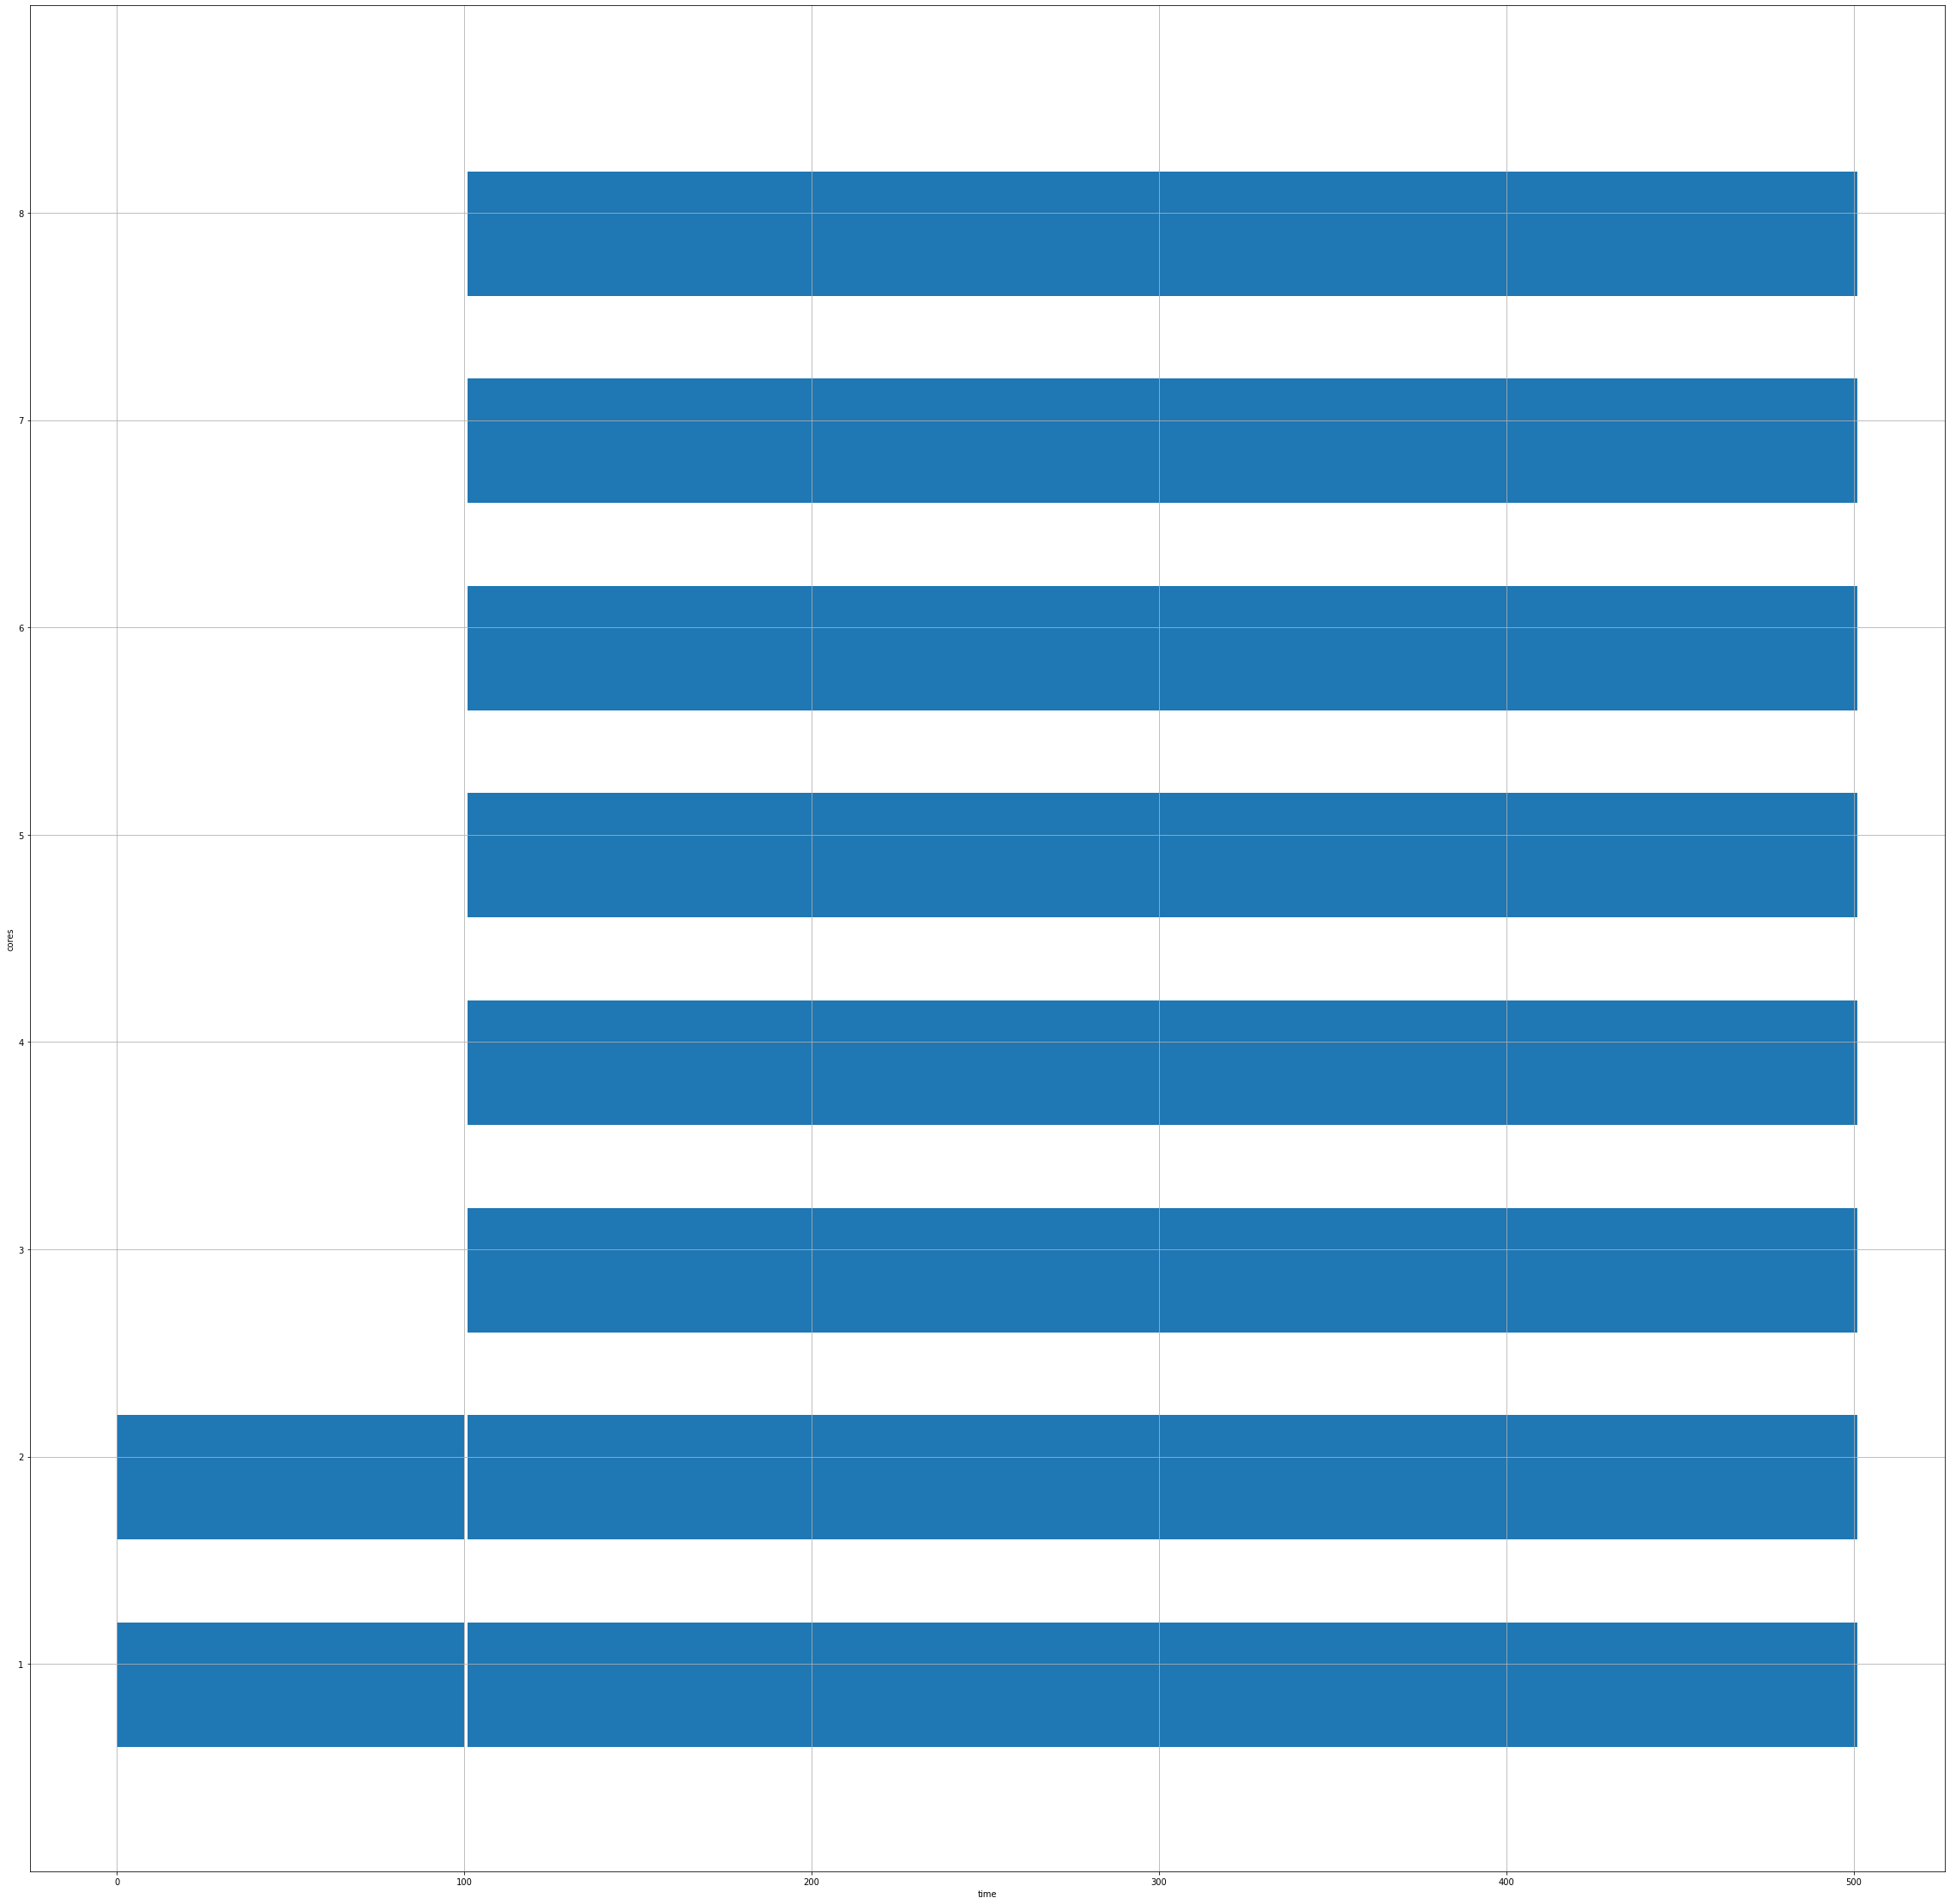

In [134]:
sched = FCFS(8)
procs = []
procs.append(Process('user', 1, 1, 0, 100))
procs.append(Process('user', 1, 1, 0, 100))
procs.append(Process('user', 2, 8, 1, 400))

procs, tot_wt, image = sched.run(procs)
for p in procs:
  print(p)
print('total wait time: {}'.format(tot_wt))
print(image.shape)
#plt.imsave('gantt.png', image)

## Sample data

In [135]:
import pandas as pd

df = pd.read_csv('/content/job_20201029.csv')
df

,JobID,UserID,SubmitTime,RunTime,CPUNum,Queue
0,1,kangseok.moon,3082,29376,8,fluent
1,2,jw.yu,5679,26745,32,fluent
2,3,giyeob.yang,25633,610,1,cfx
3,4,giyeob.yang,25633,720,32,cfx
4,5,minsock.kim,26555,7052,1,cfx
...,...,...,...,...,...,...
382,383,jongjin.bae,83871,13151,128,fluent
383,384,daeseong.woo,84534,1826,128,fluent
384,385,byeonghun.kim,84886,1588,128,fluent
385,386,yh89.lee,84915,914,128,fluent


In [136]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (40, 40)

job_color_map = {}
n_colors = len(df['UserID'].unique()) * len(df['Queue'].unique())

def get_cmap(n, name='hsv'):
  return plt.cm.get_cmap(name, n)

cmap = get_cmap(n_colors)
cmap_index = 0

for i, row in df.iterrows():
  key = (row['UserID'], row['Queue'])
  if key not in job_color_map:
    job_color_map[key] = cmap(cmap_index)
    cmap_index += 1


cur_time adjusted: 5679 fluent 26745
cur_time adjusted: 25633 cfx 610
cur_time adjusted: 26555 cfx 7052
cur_time adjusted: 26593 cfx 21618
cur_time adjusted: 27919 cfx 21602
cur_time adjusted: 27971 fluent 4513
cur_time adjusted: 28247 cfx 172799
cur_time adjusted: 28248 cfx 614
cur_time adjusted: 28249 cfx 717
cur_time adjusted: 28359 cfx 805
cur_time adjusted: 28369 cfx 85436
cur_time adjusted: 28374 cfx 85467
cur_time adjusted: 28590 cfx 619
cur_time adjusted: 28825 fluent 918
cur_time adjusted: 29176 cfx 20777
cur_time adjusted: 29502 cfx 21598
cur_time adjusted: 29739 fluent 30195
cur_time adjusted: 29800 cfx 21608
cur_time adjusted: 29938 fluent 2791
cur_time adjusted: 30166 fluent 19680
cur_time adjusted: 30296 cfx 2686
cur_time adjusted: 30405 fluent 20457
cur_time adjusted: 30822 cfx 21614
cur_time adjusted: 31060 fluent 28514
cur_time updated: 201047 fluent 28514
cur_time updated: 229562 fluent 22010
cur_time updated: 315988 fluent 22378
cur_time updated: 402476 fluent 3853
c

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f5fab520d08> (for post_execute):


KeyboardInterrupt: ignored

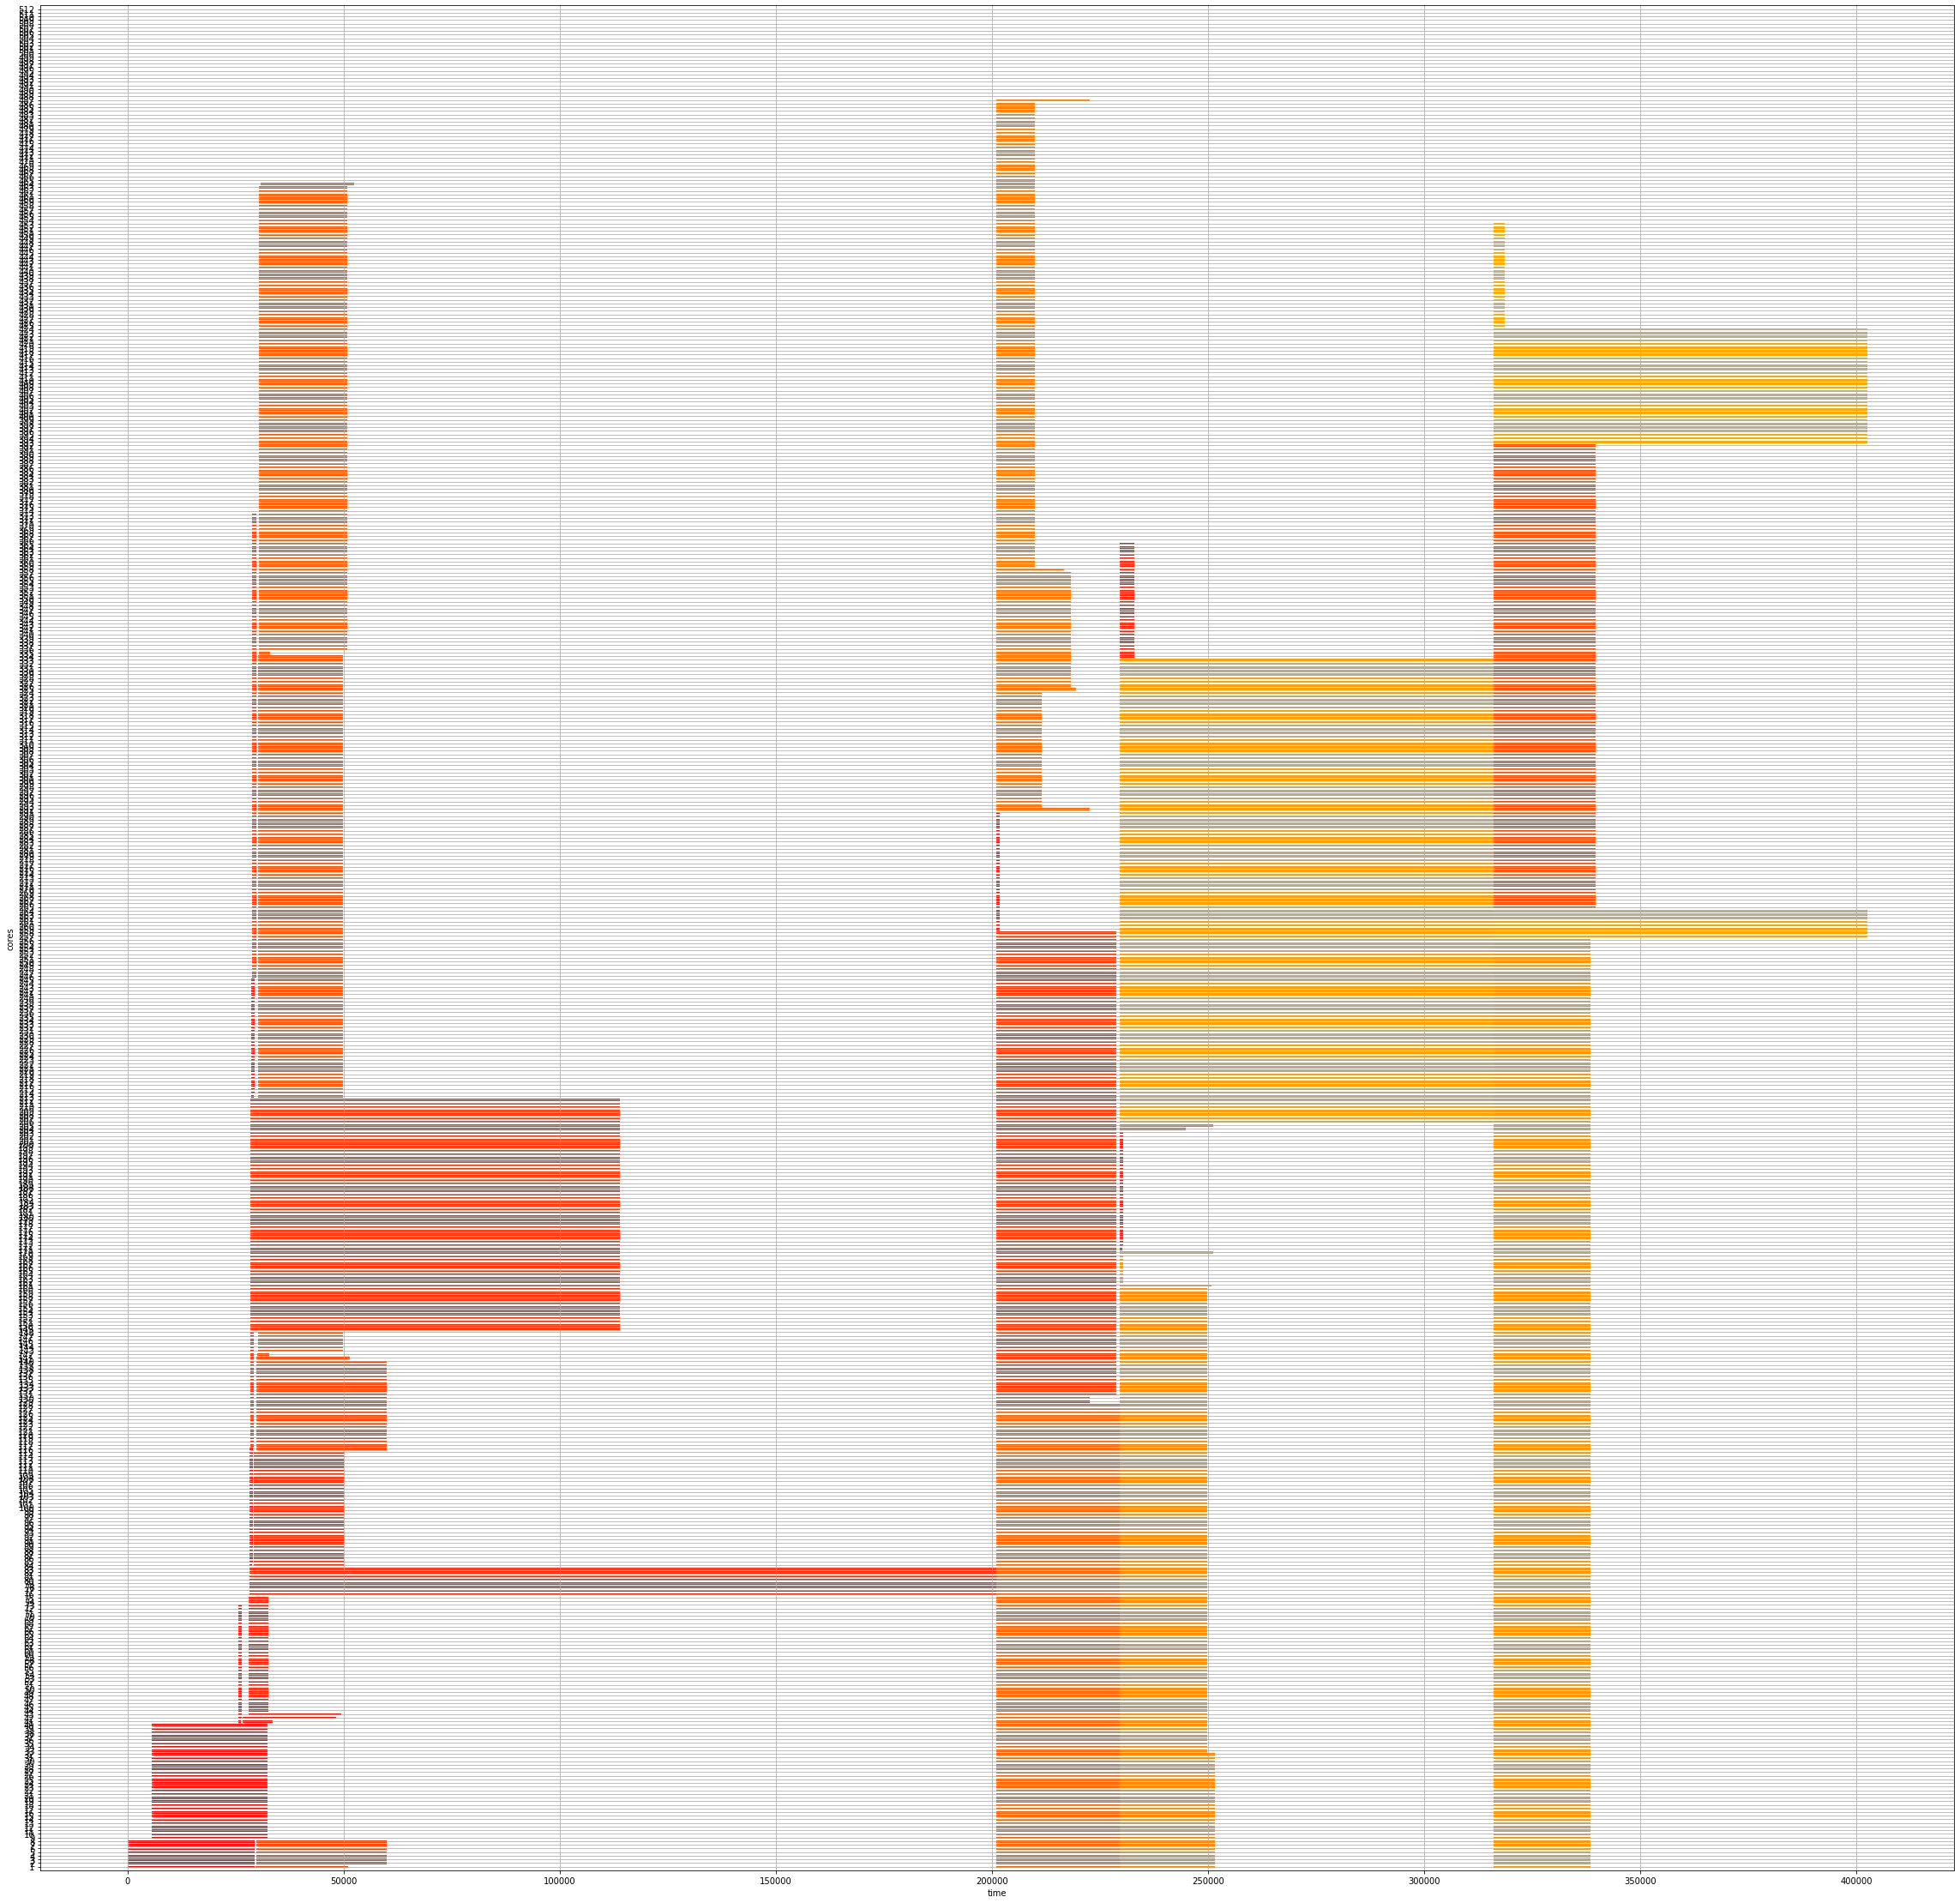

In [137]:
procs = []

for i, row in df.iterrows():
  user = row['UserID']
  sw_type = row['Queue']
  requested_n_cores = row['CPUNum']
  submit_time = row['SubmitTime']
  burst_time = row['RunTime']
  p = Process(user=user,
              sw_type=sw_type,
              requested_n_cores=requested_n_cores,
              submit_time=submit_time,
              burst_time=burst_time
              )
  procs.append(p)

sched = FCFS(n_cores=512,
             start_time_offset=df['SubmitTime'].min(),
             color_map=job_color_map)

procs, tot_wt, image = sched.run(procs)
for p in procs:
  print(p)
print('total wait time: {}'.format(tot_wt))
print(image.shape)